This notebook shows how to use the `astroquery` package (part of `astropy`) to query the Gaia variable star tables and how to obtain the light curves via the datalinks interface

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from astroquery.gaia import Gaia 

In this example we will query the [`vari_eclipsing_binary`](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_variability_tables/ssec_dm_vari_eclipsing_binary.html) table and select the top 10 sources according to the `global_ranking` column. We will also retrieve the fundamental frequency. I will be using `pandas` DataFrames to manipulate the tables

In [2]:
query = """
select top 10 source_id,frequency, global_ranking 
from gaiadr3.vari_eclipsing_binary 
order by global_ranking desc
"""

job = Gaia.launch_job(query)
eclipsing_binaries = job.get_results().to_pandas("source_id")
eclipsing_binaries

,frequency,global_ranking
source_id,,
3129144706069228928,1.746188,0.842134
4185297337638694528,0.533663,0.829747
3326843532470471168,2.665704,0.819494
3342230338707766912,0.639434,0.817321
4100457405574370176,2.455824,0.816518
6751021430570803968,0.389874,0.813557
6095201502389599488,0.957006,0.811477
3341917626431837824,0.045527,0.810064
4092207868554142976,0.118099,0.808853


The light curves are obtained using the datalinks interface. In this case we retrieve the Data Release 3 light curves for the sources we just queried with all their bands and flags. This returns a dictionary as shown below

In [3]:
datalink = Gaia.load_data(ids=eclipsing_binaries.index, 
                          data_release='Gaia DR3', 
                          retrieval_type='EPOCH_PHOTOMETRY', 
                          format='csv', 
                          valid_data=False)

type(datalink), len(datalink)

(dict, 10)

Let's inspect the key and data of the first item in the dictionary:

In [4]:
for key, value in datalink.items():
    break
print(key)
lc = value[0].to_pandas()
lc

EPOCH_PHOTOMETRY-Gaia DR3 3341917626431837824.csv


,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,3341917626431837824,17722668405638070,G,1717.348278,13.212763,97688.035299,68.983018,1416.11720,false,false,4210691,375316653866487564
1,3341917626431837824,19614269029656368,G,1751.560190,13.160409,102514.022145,281.687370,363.92834,false,false,4097,375316653866487564
2,3341917626431837824,19624009851369186,G,1751.736363,13.155086,103017.812906,97.622350,1055.26870,false,false,4097,375316653866487564
3,3341917626431837824,26693159889727807,G,1879.578511,13.798387,56962.872320,32.958801,1728.30530,false,false,1,375316653866487564
4,3341917626431837824,28154014457549765,G,1905.994808,13.146460,103839.522834,69.001891,1504.87940,false,false,1,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
79,3341917626431837824,70200335679910576,RP,2666.378736,12.330890,92640.742474,143.191378,646.97150,false,false,0,375316653866487564
80,3341917626431837824,70933272839091153,RP,2679.632481,12.497219,79482.295874,133.146955,596.95166,false,false,0,375316653866487564
81,3341917626431837824,70937365082470137,RP,2679.706482,12.512562,78367.064234,132.715887,590.48740,false,false,0,375316653866487564
82,3341917626431837824,70947105903481446,RP,2679.882624,12.557979,75156.476509,135.241794,555.71930,false,false,0,375316653866487564


Now let's plot the light curve. We can omit outliers in the raw data using the flag "rejected_by_variability"

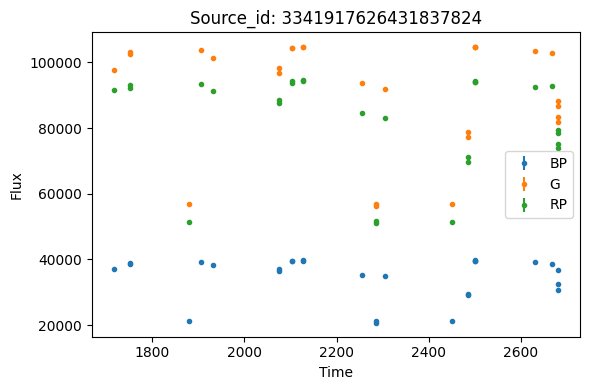

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

for name, data in lc.groupby("band"):
    mask = data["rejected_by_variability"]=="false"
    mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
    ax.errorbar(mjd, flux, flux_err, fmt='.', label=name)
    
ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax.legend();

The period of this light curve is

In [6]:
sid = lc["source_id"].loc[0]

period = 1./eclipsing_binaries["frequency"].loc[sid]
period

21.96482954227216

With the period we can visualize the phase diagram (folded light curve)

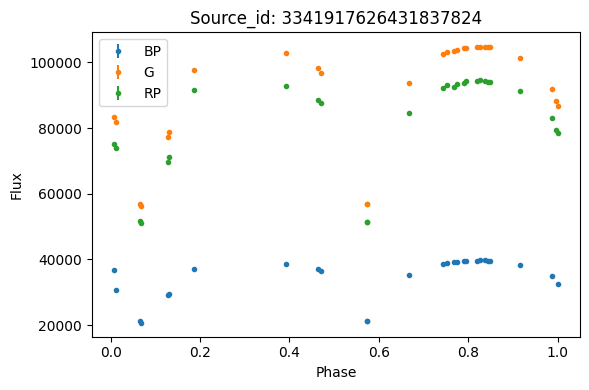

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

for name, data in lc.groupby("band"):
    mask = data["rejected_by_variability"]=="false"
    mjd, flux, flux_err = data.loc[mask][['time', 'flux', 'flux_error']].values.T
    phase = np.mod(mjd, period)/period
    ax.errorbar(phase, flux, flux_err, fmt='.', label=name)
    
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')
ax.set_title(f'Source_id: {lc["source_id"].loc[0]}')
ax.legend();

In this case we know that this source corresponds to an eclipsing binary. But in the more general case, for a given sourceid, we can fint its Gaia classification by querying the `vari_classifier_result` table:

In [8]:
job = Gaia.launch_job_async(f'select * from gaiadr3.vari_classifier_result where source_id = {lc["source_id"].loc[0]}' )
classifier = job.get_results().to_pandas(index="source_id")
classifier.T

INFO: Query finished. [astroquery.utils.tap.core]


source_id,3341917626431837824
solution_id,375316653866487564
classifier_name,nTransits:5+
best_class_name,ECL
best_class_score,0.222571


Finally, we can query the variability features in the [`vari_summary`](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_variability_tables/) table for this particular source with

In [9]:
job = Gaia.launch_job_async(f'select * from gaiadr3.vari_summary where source_id = {lc["source_id"].loc[0]}' )
features = job.get_results().to_pandas(index="source_id")
features.T

INFO: Query finished. [astroquery.utils.tap.core]


source_id,3341917626431837824
solution_id,375316653866487564
num_selected_g_fov,28
mean_obs_time_g_fov,2272.131907
time_duration_g_fov,962.607971
min_mag_g_fov,13.136956
...,...
in_vari_rotation_modulation,False
in_vari_ms_oscillator,False
in_vari_agn,False
in_vari_microlensing,False
